In [4]:
import numpy as np
import geopandas
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from pysheds.grid import Grid
from pygeotools.lib import geolib,iolib
from imview.lib import pltlib

In [2]:
ds = iolib.fn_getds('reprojected_DEM.tif')
grid = Grid.from_raster('reprojected_DEM.tif','dem')
grid.fill_depressions(data='dem',out_name='filled_dem',nodata_in=grid.nodata,nodata_out=grid.nodata)
grid.resolve_flats(data='filled_dem',nodata_in=grid.nodata,nodata_out=grid.nodata,out_name='filled_flats_dem')
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
grid.flowdir('filled_flats_dem',out_name='dir',dirmap=dirmap)
grid.accumulation(data='dir',out_name='acc',nodata_in=grid.nodata,nodata_out=grid.nodata)
grid.read_raster('final_watershed.tif','catch')
grid.clip_to('catch')
flow_acc_catchment = np.ma.masked_where(grid.view('acc')==grid.nodata,(grid.view('acc')))
flow_dir_catchment = np.ma.fix_invalid(grid.view('dir'))

/home/shashank/.conda/envs/bhushanPy3/lib/python3.6/site-packages/pysheds-0.2.2-py3.6.egg/pysheds/grid.py:2932: RuntimeWarning: overflow encountered in add


In [13]:
filled_dem = np.ma.masked_where(grid.view('filled_flats_dem')==grid.nodata,(grid.view('filled_flats_dem')))
flow_acc_catchment = np.ma.masked_where(grid.view('acc')==grid.nodata,(grid.view('acc')))
flow_dir_catchment = np.ma.fix_invalid(grid.view('dir'))

<IPython.core.display.Javascript object>


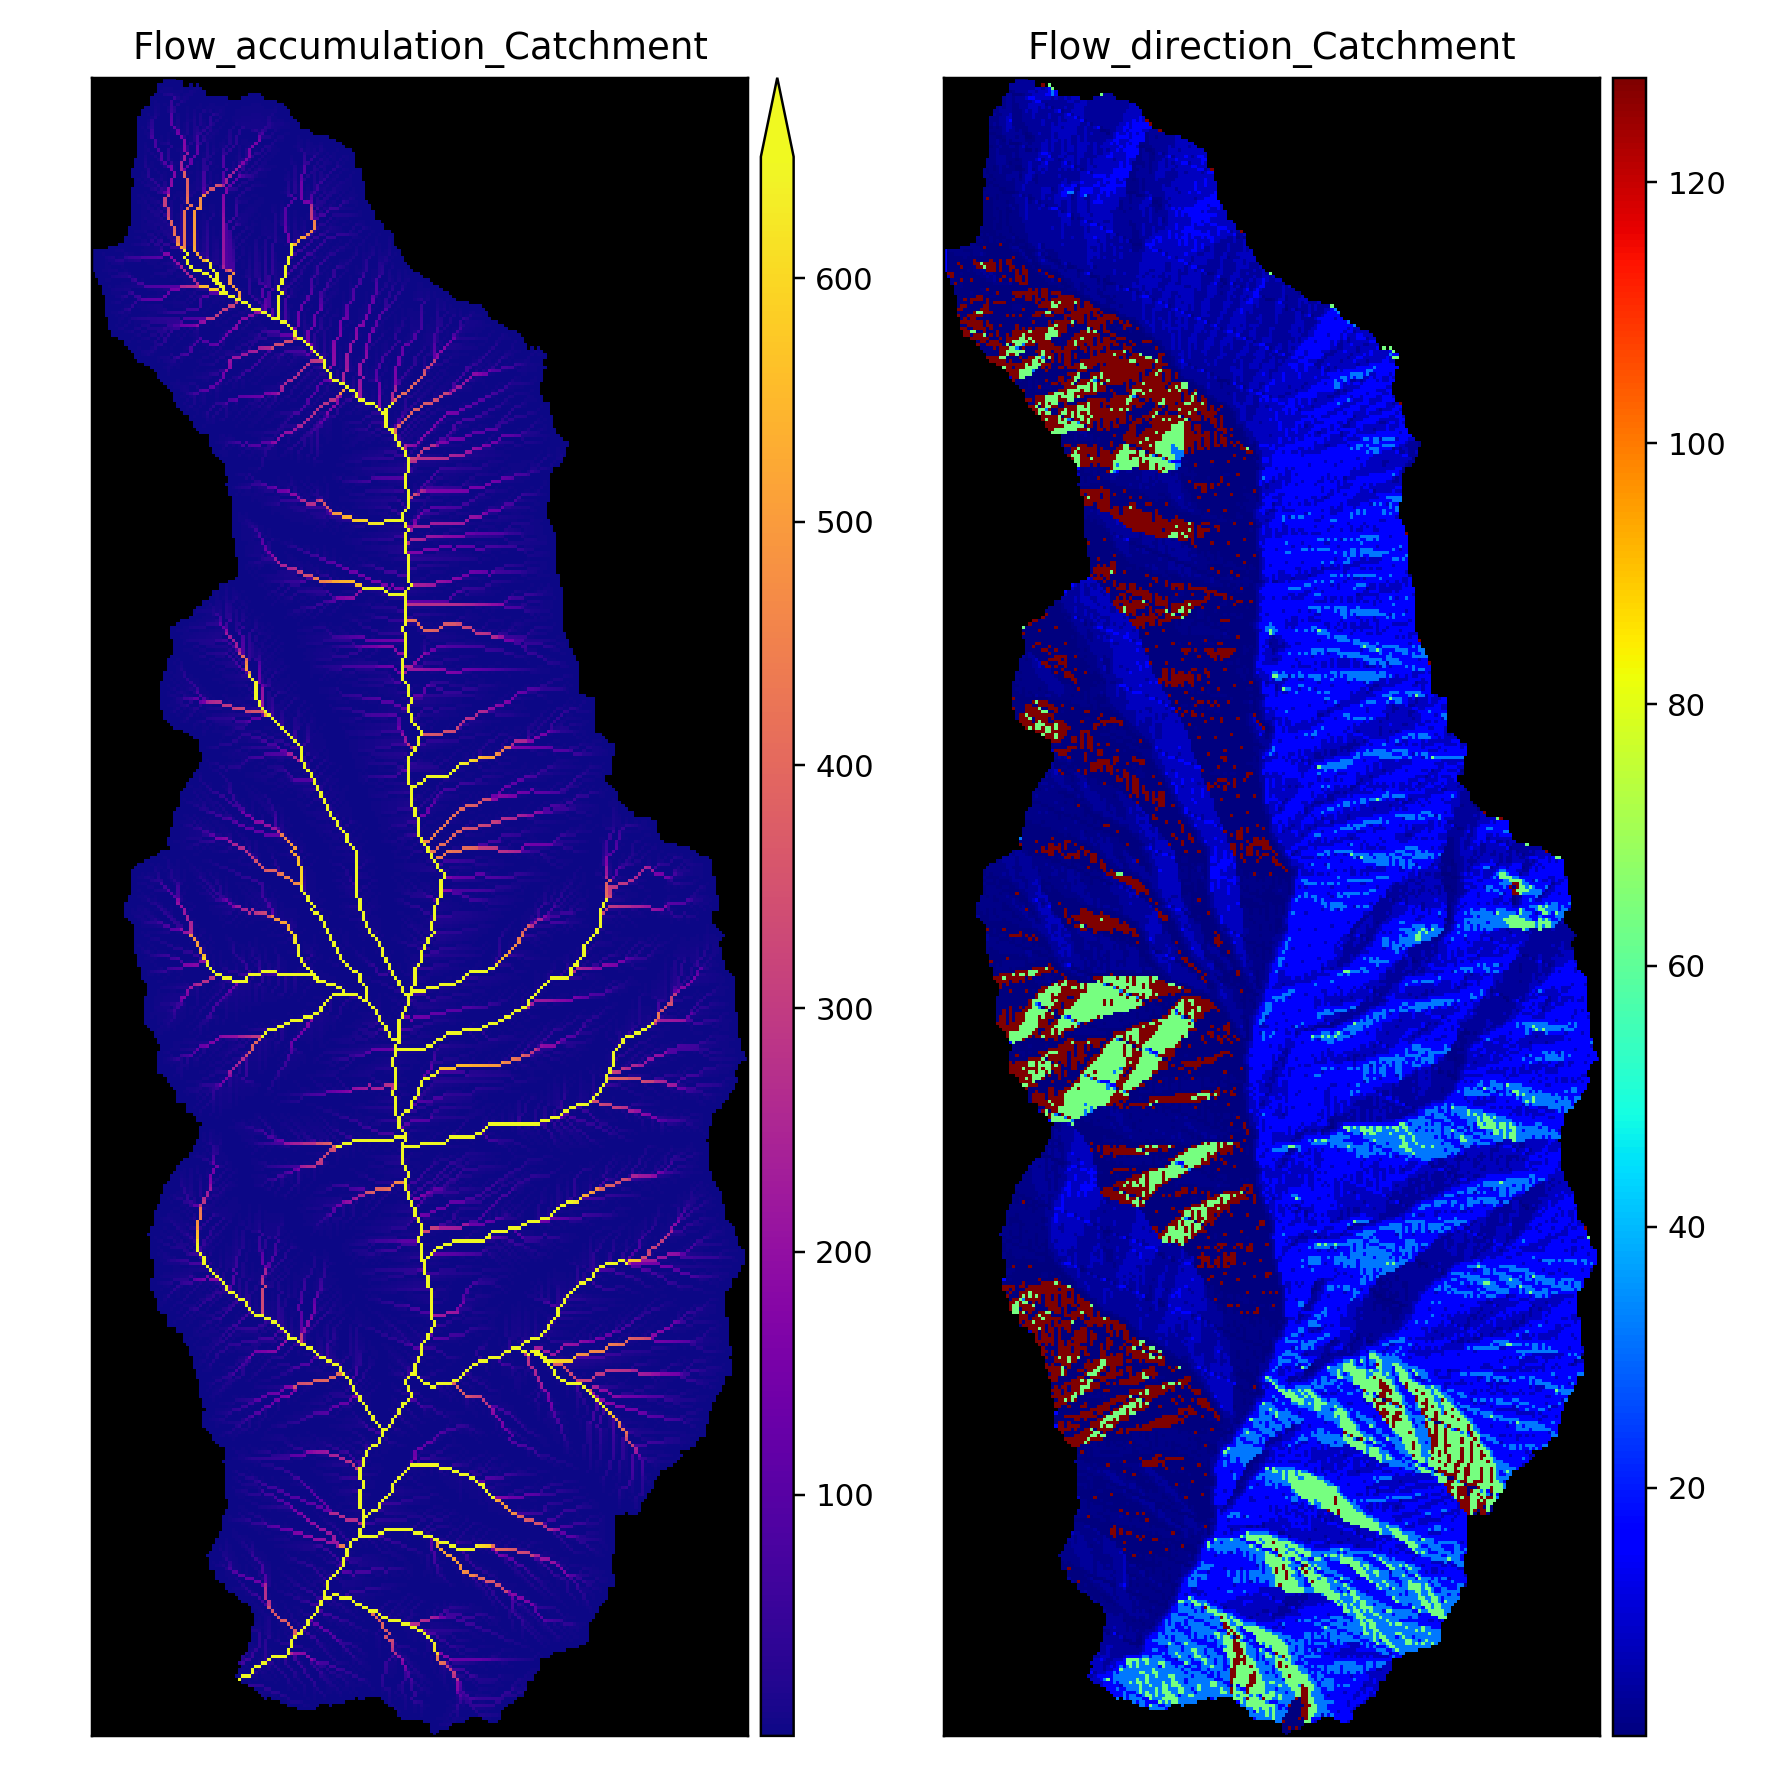

In [8]:
fig,ax = plt.subplots(1,2,figsize=(8,8))
pltlib.iv(flow_acc_catchment,ax=ax[0],cmap='plasma',title='Flow_accumulation_Catchment')
pltlib.iv(flow_dir_catchment,ax=ax[1],cmap='jet',title='Flow_direction_Catchment')
fig.savefig('Flow_accumulation_direction.png',dpi=600)

In [10]:
ds.GetGeoTransform()[1]

28.89036664823402

In [11]:
catchment_area = flow_acc_catchment*ds.GetGeoTransform()[1]

/home/shashank/.conda/envs/bhushanPy3/lib/python3.6/site-packages/numpy/ma/core.py:1019: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [14]:
iolib.writeGTiff(filled_dem,'Final_filled_DEM.tif',ds)

In [16]:
!gdaldem slope -p Final_filled_DEM.tif Percent_Slope.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [17]:
percent_slope_catchment = iolib.fn_getma('Percent_Slope.tif')

<IPython.core.display.Javascript object>


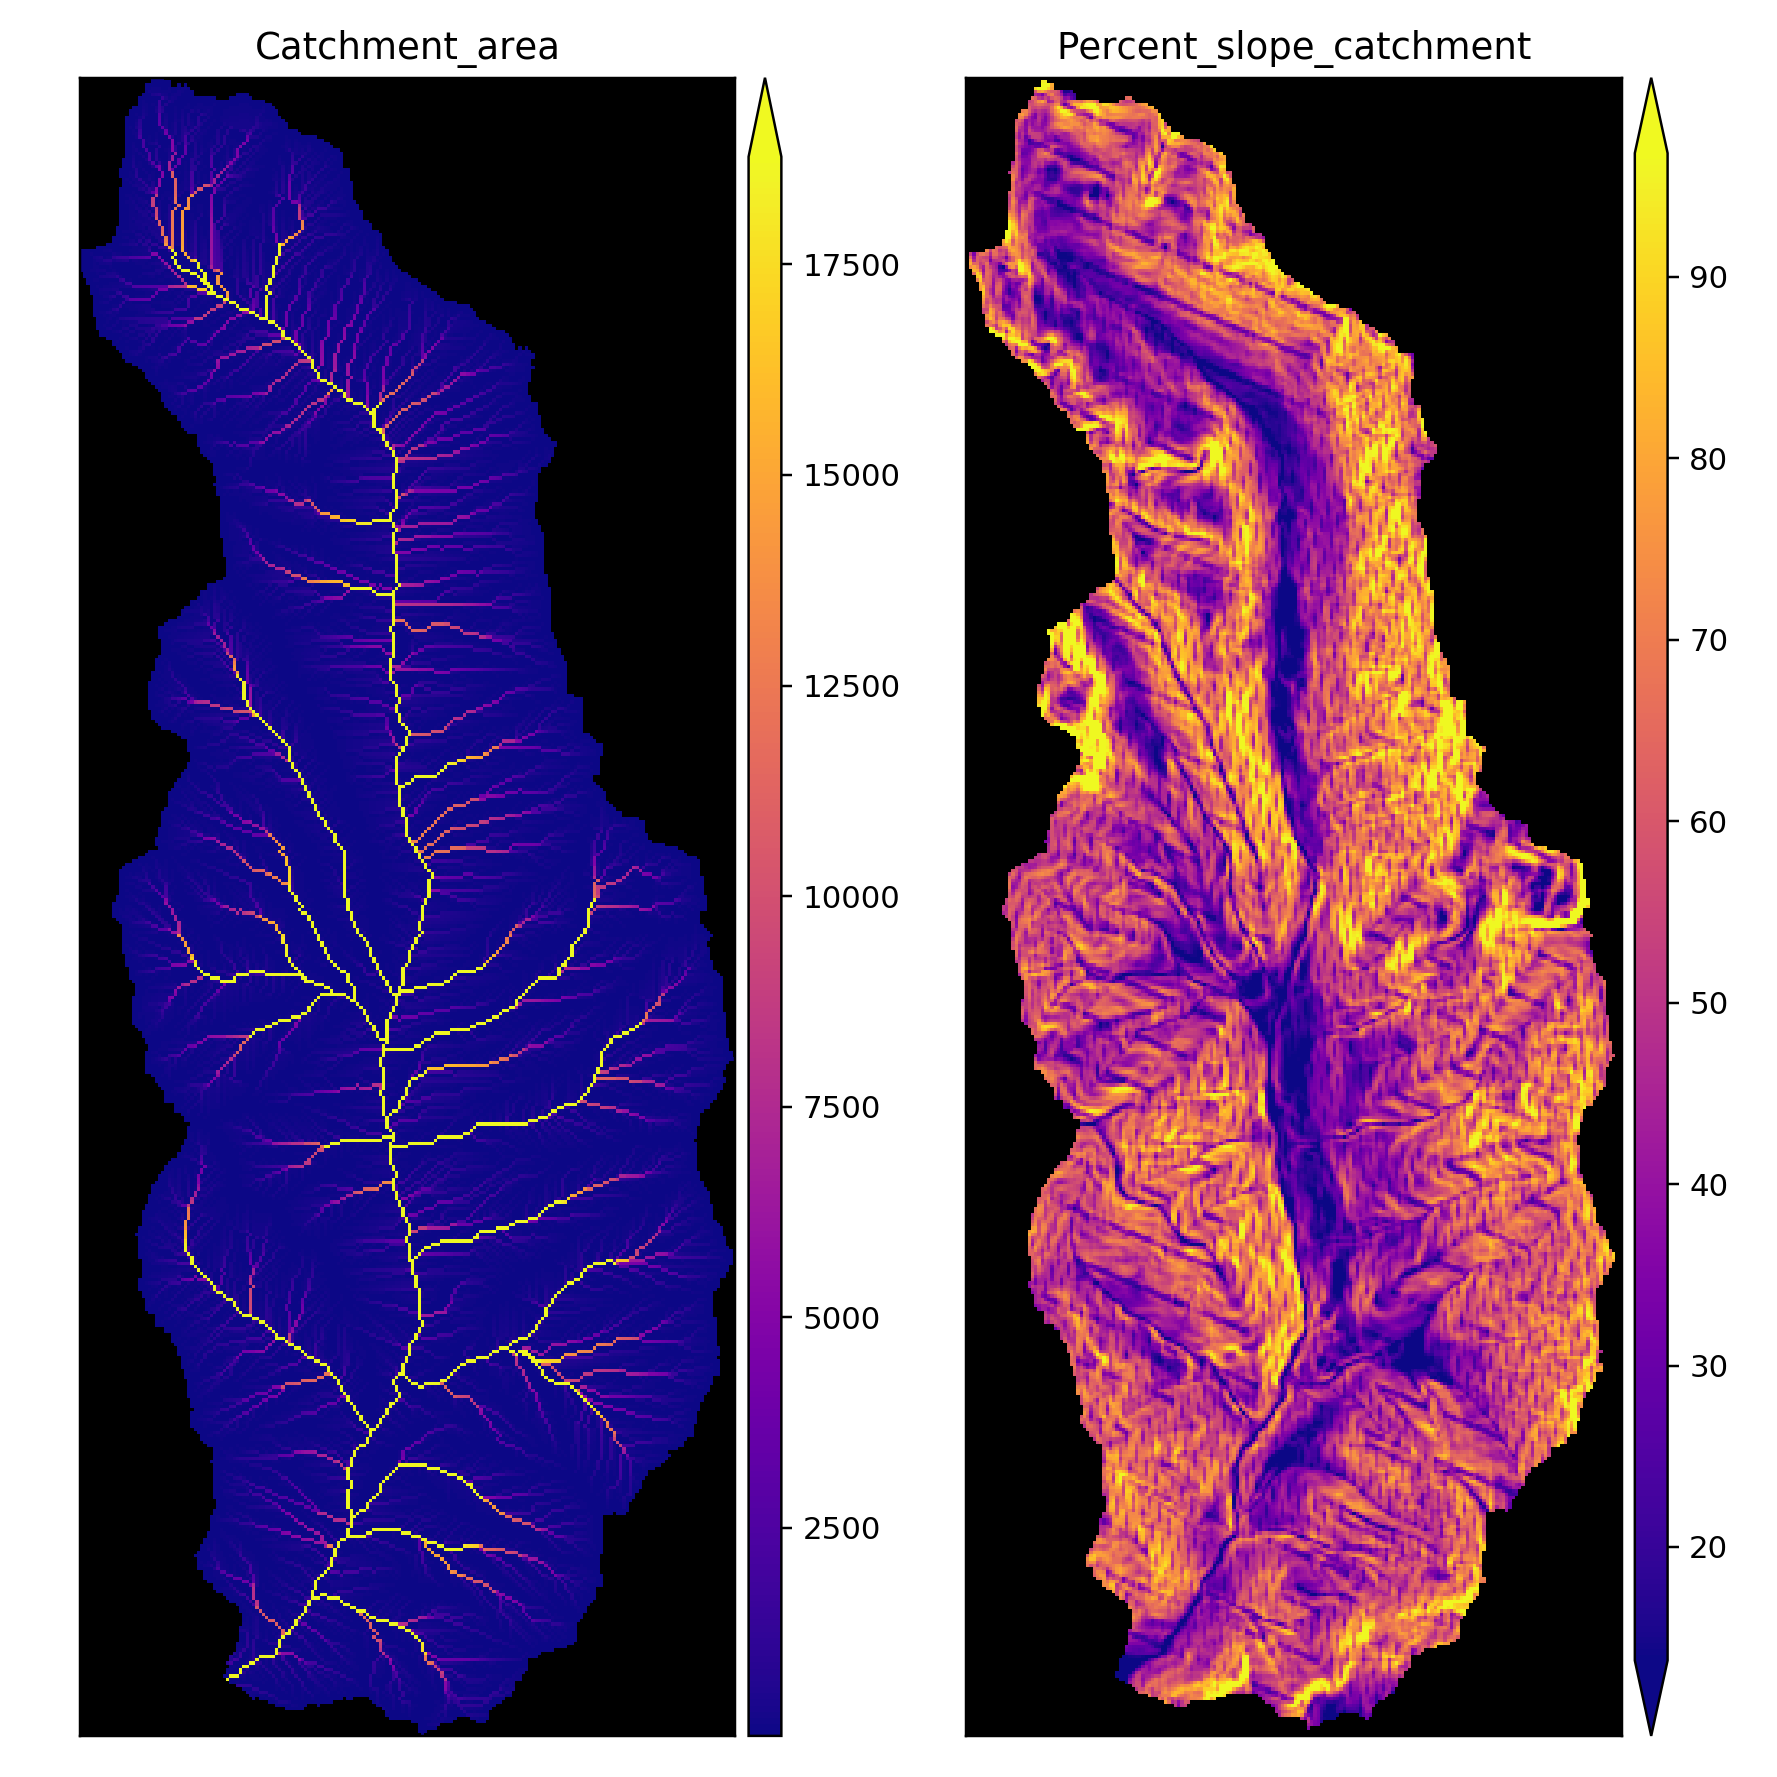

In [18]:
fig,ax = plt.subplots(1,2,figsize=(8,8))
pltlib.iv(catchment_area,ax=ax[0],cmap='plasma',title='Catchment_area')
pltlib.iv(percent_slope_catchment,ax=ax[1],cmap='plasma',title='Percent_slope_catchment')
fig.savefig('Catchment_area_slope.png',dpi=600)

In [28]:
#Converting slope percent to slope
slope = percent_slope_catchment*0.01
#masking slope less than or equal to 0.0
slope = np.ma.masked_less_equal(slope,0)
print ("Least value of slope is = "+str(np.ma.min(slope)))

Least value of slope is = 0.005154003


In [31]:
top_model_values = np.ma.log(catchment_area/(slope))

In [32]:
print ('Maximum wetness index = '+ str(np.ma.max(top_model_values)))
print ('Minimum wetness index = '+ str(np.ma.min(top_model_values)))
print ('Mean wetness index = '+ str(np.ma.mean(top_model_values)))

Maximum wetness index = 18.865674848110217
Minimum wetness index = 2.653636410881833
Mean wetness index = 5.730137630068871


In [33]:
val,edge = np.histogram(np.ma.compressed(top_model_values),bins = 20, normed =True)

/home/shashank/.conda/envs/bhushanPy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


In [35]:
edge

array([ 2.65363641,  3.46423833,  4.27484025,  5.08544218,  5.8960441 ,
        6.70664602,  7.51724794,  8.32784986,  9.13845179,  9.94905371,
       10.75965563, 11.57025755, 12.38085947, 13.1914614 , 14.00206332,
       14.81266524, 15.62326716, 16.43386908, 17.244471  , 18.05507293,
       18.86567485])

<IPython.core.display.Javascript object>


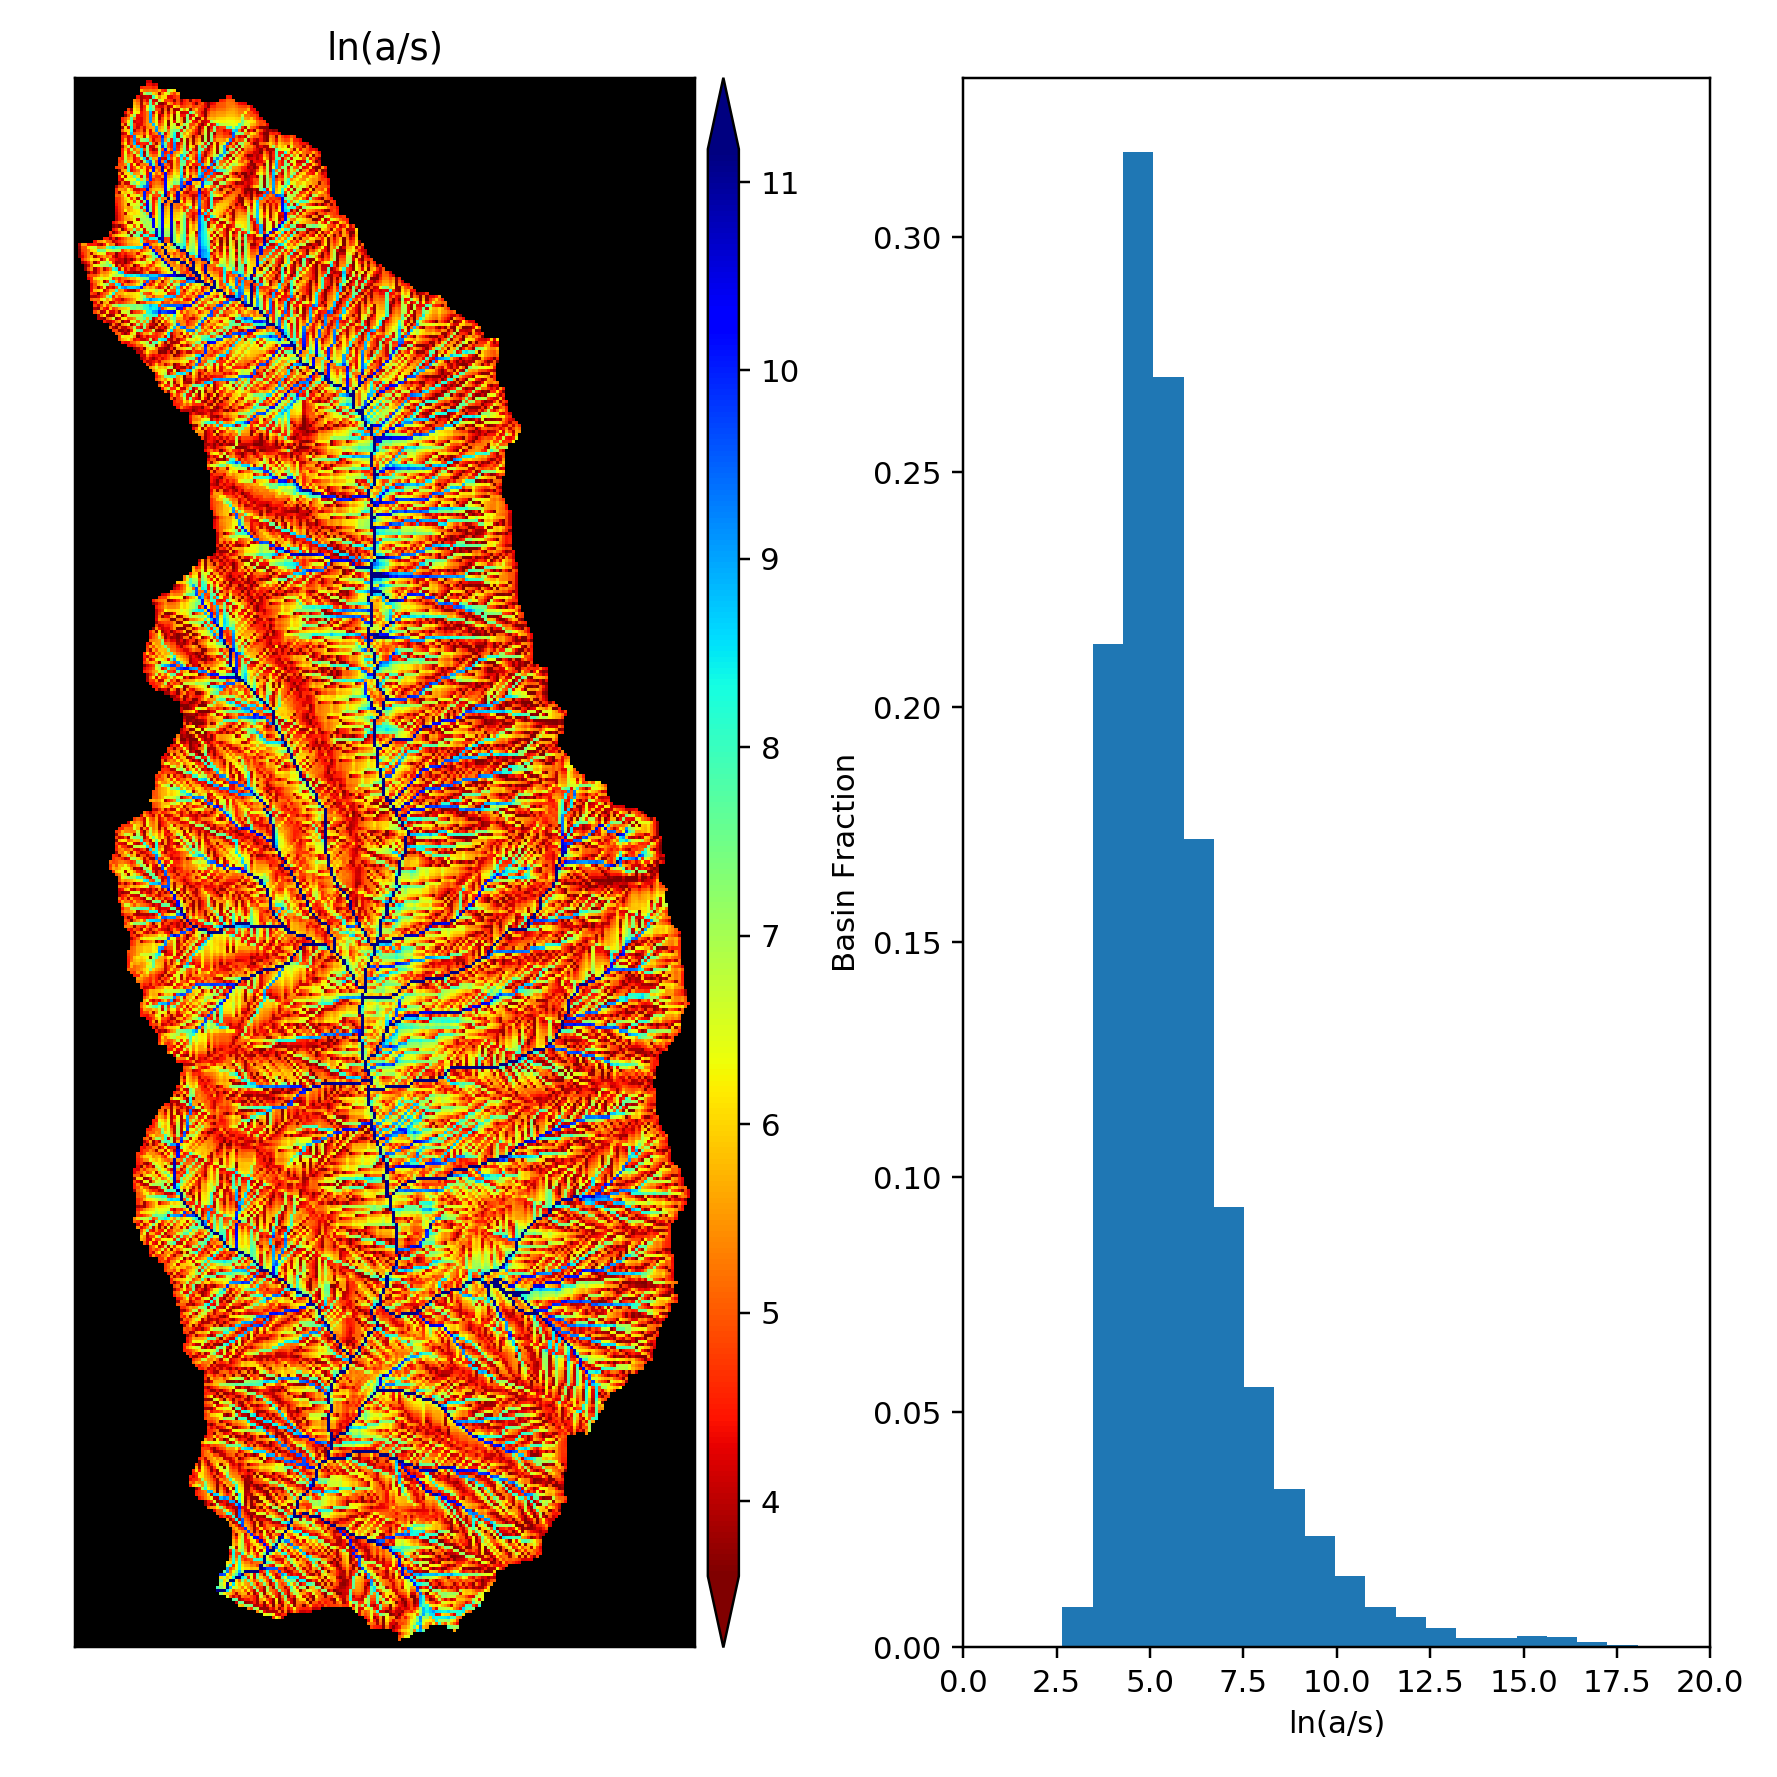

/home/shashank/.conda/envs/bhushanPy3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


In [43]:
fig,ax = plt.subplots(1,2,figsize=(8,8))
pltlib.iv(top_model_values,ax=ax[0],title='ln(a/s)',cmap='jet_r')
ax[1].hist(np.ma.compressed(top_model_values),bins = 20, normed =True)
ax[1].set_xlabel('ln(a/s)')
ax[1].set_ylabel('Basin Fraction')
ax[1].set_xlim(0,20)
plt.tight_layout()
fig.savefig('Wetness_index.png',dpi=600)
